# Hyperparameters Tunning using Optuna (Hyperparameter Optimization Framework)

## Import Libraries

In [31]:
# install optuna
import sys
import subprocess
import importlib.util

package_name = 'optuna'

if importlib.util.find_spec(package_name) is None:
    print(f"Installing {package_name}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
else:
    print(f"{package_name} is already installed. Skipping.")

optuna is already installed. Skipping.


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import kagglehub
import random
import matplotlib.pyplot as plt
import optuna

In [33]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Loading the Dataset

In [34]:
dataset_path = kagglehub.dataset_download('zalando-research/fashionmnist')
csv_file_path = f'{dataset_path}/fashion-mnist_train.csv'
df_train = pd.read_csv(csv_file_path)

Using Colab cache for faster access to the 'fashionmnist' dataset.


In [35]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
df_train.shape

(60000, 785)

In [37]:
csv_file_path = f'{dataset_path}/fashion-mnist_test.csv'
df_test = pd.read_csv(csv_file_path)

In [38]:
df_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
df_test.shape

(10000, 785)

## Viewing the Random Image

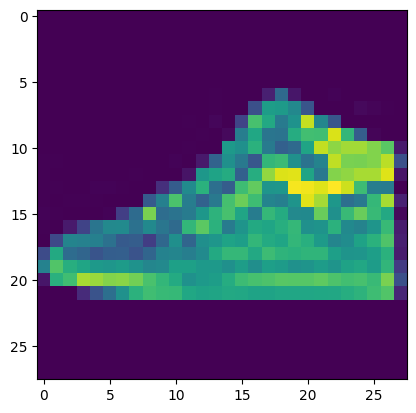

In [40]:
# train image
random_index = random.randint(0,len(df_train))
image = df_train.iloc[random_index,1:].values.reshape(28,28)
plt.imshow(image)
plt.show()

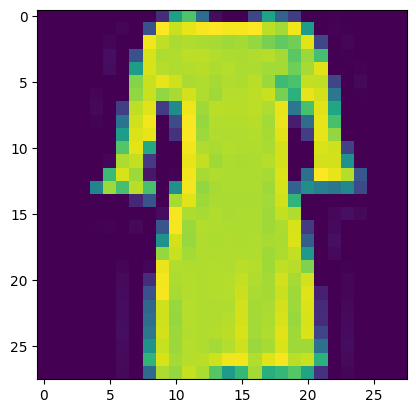

In [41]:
# test image
random_index = random.randint(0,len(df_test))
image = df_test.iloc[random_index,1:].values.reshape(28,28)
plt.imshow(image)
plt.show()

## Splitting the Dataset into Training and Testing Sets

In [42]:
X_train = df_train.iloc[:, 1:].values
y_train = df_train.iloc[:, 0].values
X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

In [43]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [44]:
X_train.shape

(60000, 784)

## Crating Custom Dataset Class

In [45]:
class CustomDataset(Dataset):

    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [46]:
train_datataset = CustomDataset(features=X_train, labels=y_train)
test_datataset = CustomDataset(features=X_test, labels=y_test)

## Model Building

In [47]:
# crating model Class
class Model(nn.Module):

    def __init__(self, input_dim, output_dim, num_hidden_layers, num_neurons):
        
        super().__init__()

        layers = []

        for i in range(num_hidden_layers):
            
            layers.append(nn.Linear(input_dim, num_neurons))
            layers.append(nn.BatchNorm1d(num_neurons))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            input_dim = num_neurons

        layers.append(nn.Linear(num_neurons, output_dim))

        self.model = nn.Sequential(*layers)

    def forward(self, features):
        
        return self.model(features)

## Objective Function for Hyperparameter Tuning

In [48]:
def objective(trial):

    # hyperparameters values
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 5)
    num_neurons = trial.suggest_int('num_neurons', 8, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    epochs = trial.suggest_int('epochs', 10, 100, step=10)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    optimizer = trial.suggest_categorical('optimizer', ['Adam','SGD','RMSprop'])
    batch_size = trial.suggest_categorical('batch_size', [32,64,128,256])

    # defining dataloaders
    train_dataloader = DataLoader(
        train_datataset, batch_size=batch_size, shuffle=True, pin_memory=True
    )
    test_dataloader = DataLoader(
        test_datataset, batch_size=batch_size, shuffle=False, pin_memory=True
    )

    # model initialization
    input_dim = X_train.shape[1]
    output_dim = 10

    model = Model(input_dim, output_dim, num_hidden_layers, num_neurons)
    model.to(device)

    # loss function
    loss_function = nn.CrossEntropyLoss()

    # selecting optimizer function according to above suggest value
    if optimizer == 'Adam':
        optimizer = optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    elif optimizer == 'SGD':
        optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    else:
        optimizer = optim.RMSprop(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # training loop
    for epoch in range(epochs):

        for batch_features, batch_labels in train_dataloader:

            # move data to gpu
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            # forward pass
            y_pred = model(batch_features)
            
            # loss calculate
            loss = loss_function(y_pred, batch_labels)
            
            # clear gradients
            optimizer.zero_grad()

            # backward pass
            loss.backward()

            # update gradients
            optimizer.step()

    # setting model to evaluation mode
    model.eval()
    
    # evaluation code
    total = 0 
    correct = 0

    with torch.no_grad():

        for batch_features, batch_labels in test_dataloader:

            # move data to gpu
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            y_pred = model(batch_features)

            _, predicted = torch.max(y_pred, 1)

            total += batch_labels.shape[0]

            correct += (predicted==batch_labels).sum().item()

        accuracy = (correct/total)*100

    return accuracy

## Creating Study of Optuna

In [49]:
study = optuna.create_study(direction='maximize')

[I 2026-01-23 17:48:04,672] A new study created in memory with name: no-name-e5f5481f-d2f5-4c22-b93d-6a8c49dabc54


In [50]:
study.optimize(objective, n_trials=10)

[I 2026-01-23 17:56:43,510] Trial 0 finished with value: 89.61 and parameters: {'num_hidden_layers': 2, 'num_neurons': 106, 'learning_rate': 0.00032286071935929425, 'epochs': 100, 'weight_decay': 0.0003177563063115717, 'optimizer': 'RMSprop', 'batch_size': 32}. Best is trial 0 with value: 89.61.
[I 2026-01-23 17:58:23,320] Trial 1 finished with value: 39.739999999999995 and parameters: {'num_hidden_layers': 5, 'num_neurons': 125, 'learning_rate': 2.3954481212069058e-05, 'epochs': 50, 'weight_decay': 4.8016842086180594e-05, 'optimizer': 'SGD', 'batch_size': 256}. Best is trial 0 with value: 89.61.
[I 2026-01-23 18:03:31,391] Trial 2 finished with value: 79.13 and parameters: {'num_hidden_layers': 3, 'num_neurons': 39, 'learning_rate': 0.00010893423638010991, 'epochs': 90, 'weight_decay': 5.354035447153639e-05, 'optimizer': 'SGD', 'batch_size': 64}. Best is trial 0 with value: 89.61.
[I 2026-01-23 18:08:13,198] Trial 3 finished with value: 70.8 and parameters: {'num_hidden_layers': 5, 'n

In [51]:
study.best_value

89.61

In [52]:
study.best_params

{'num_hidden_layers': 2,
 'num_neurons': 106,
 'learning_rate': 0.00032286071935929425,
 'epochs': 100,
 'weight_decay': 0.0003177563063115717,
 'optimizer': 'RMSprop',
 'batch_size': 32}